In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.5), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.5
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1),F.softmax(x,dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.io import read_tu_data
import os.path as osp

class GraphDataset(InMemoryDataset):
    def __init__(self, root, name, transform=None, pre_transform=None,
                 pre_filter=None, use_node_attr=False, use_edge_attr=False):
        self.name = name
        super(GraphDataset, self).__init__(root, transform, pre_transform,
                                        pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        if self.data.x is not None and not use_node_attr:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, num_node_attributes:]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

    @property
    def raw_dir(self):
        name = 'raw{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def processed_dir(self):
        name = 'processed{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator','graph_labels','node_attributes','node_labels']
        return ['{}_{}.txt'.format(self.name, name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        self.data, self.slices = read_tu_data(self.raw_dir, self.name)

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))

Sorry no gpu found!!
Running model on cpu
**********
1000
3
16
0.5
2
**********
Running for 1 fold
800 200
Epoch 0. Train Loss: 0.0257. Train accuracy: 1.0000
Epoch 1. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 2. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 3. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 4. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 5. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 6. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 7. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 8. Train Loss: 0.0000. Train accuracy: 1.0000
Epoch 9. Train Loss: 0.0000. Train accuracy: 1.0000
Time taken for training:  1495.9876160621643
F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[ 87   0]
 [  0 113]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.00000   1.00000   1.00000       113

    accuracy                        1.00000       200


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[449   0]
 [  0 451]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       449
           1    1.00000   1.00000   1.00000       451

    accuracy                        1.00000       900
   macro avg    1.00000   1.00000   1.00000       900
weighted avg    1.00000   1.00000   1.00000       900

Test accuracy: 1.0000
Train ratio: 0.2. No of training graphs: 200. No of testing graphs: 800


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[399   0]
 [  0 401]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       399
           1    1.00000   1.00000   1.00000       401

    accuracy                        1.00000       800
   macro avg    1.00000   1.00000   1.00000       800
weighted avg    1.00000   1.00000   1.00000       800

Test accuracy: 1.0000
Train ratio: 0.3. No of training graphs: 300. No of testing graphs: 700


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[347   0]
 [  0 353]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       347
           1    1.00000   1.00000   1.00000       353

    accuracy                        1.00000       700
   macro avg    1.00000   1.00000   1.00000       700
weighted avg    1.00000   1.00000   1.00000       700

Test accuracy: 1.0000
Train ratio: 0.4. No of training graphs: 400. No of testing graphs: 600


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[300   0]
 [  0 300]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       300
           1    1.00000   1.00000   1.00000       300

    accuracy                        1.00000       600
   macro avg    1.00000   1.00000   1.00000       600
weighted avg    1.00000   1.00000   1.00000       600

Test accuracy: 1.0000
Train ratio: 0.5. No of training graphs: 500. No of testing graphs: 500


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[247   0]
 [  0 253]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       247
           1    1.00000   1.00000   1.00000       253

    accuracy                        1.00000       500
   macro avg    1.00000   1.00000   1.00000       500
weighted avg    1.00000   1.00000   1.00000       500

Test accuracy: 1.0000
Train ratio: 0.6. No of training graphs: 600. No of testing graphs: 400


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[199   0]
 [  0 201]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       199
           1    1.00000   1.00000   1.00000       201

    accuracy                        1.00000       400
   macro avg    1.00000   1.00000   1.00000       400
weighted avg    1.00000   1.00000   1.00000       400

Test accuracy: 1.0000
Train ratio: 0.7. No of training graphs: 700. No of testing graphs: 300


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[143   0]
 [  0 157]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       143
           1    1.00000   1.00000   1.00000       157

    accuracy                        1.00000       300
   macro avg    1.00000   1.00000   1.00000       300
weighted avg    1.00000   1.00000   1.00000       300

Test accuracy: 1.0000
Train ratio: 0.8. No of training graphs: 800. No of testing graphs: 200


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[ 87   0]
 [  0 113]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.00000   1.00000   1.00000       113

    accuracy                        1.00000       200
   macro avg    1.00000   1.00000   1.00000       200
weighted avg    1.00000   1.00000   1.00000       200

Test accuracy: 1.0000
Train ratio: 0.9. No of training graphs: 900. No of testing graphs: 100


D:\Anaconda\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[48  0]
 [ 0 52]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        48
           1    1.00000   1.00000   1.00000        52

    accuracy                        1.00000       100
   macro avg    1.00000   1.00000   1.00000       100
weighted avg    1.00000   1.00000   1.00000       100

Test accuracy: 1.0000


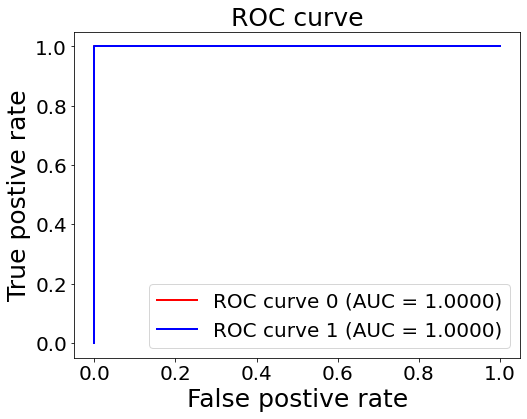

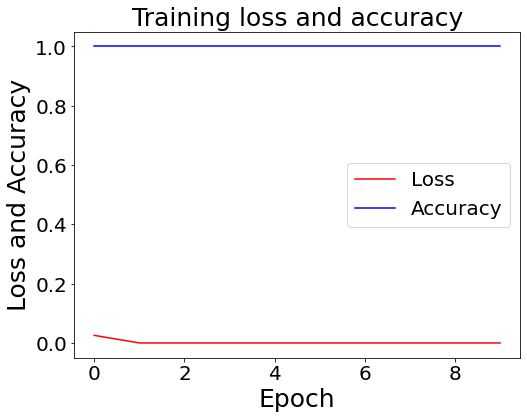

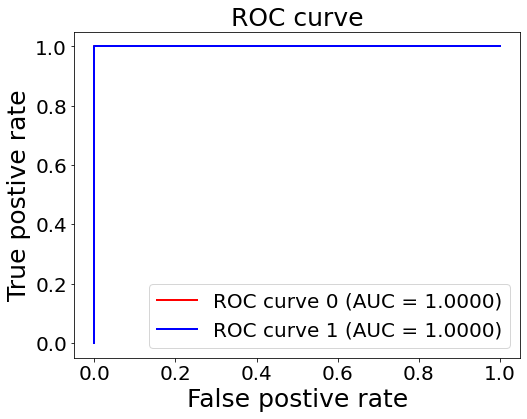

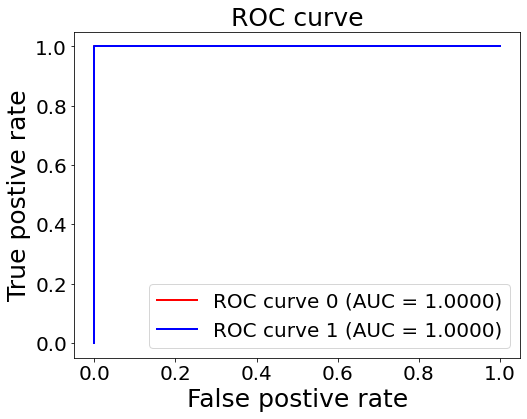

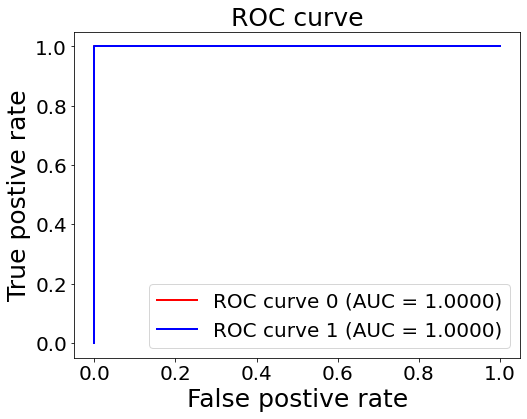

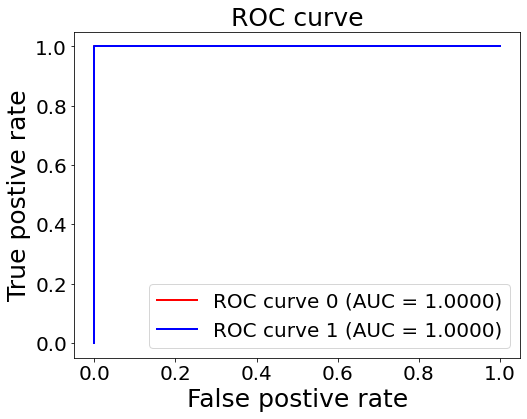

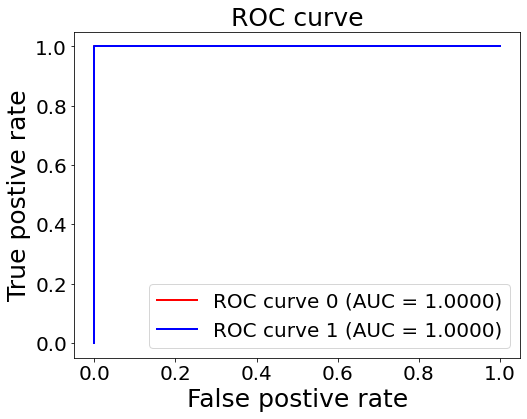

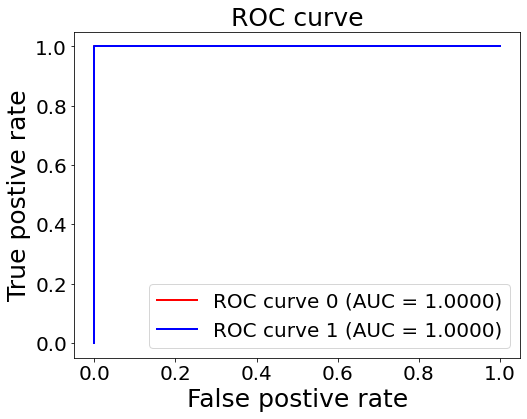

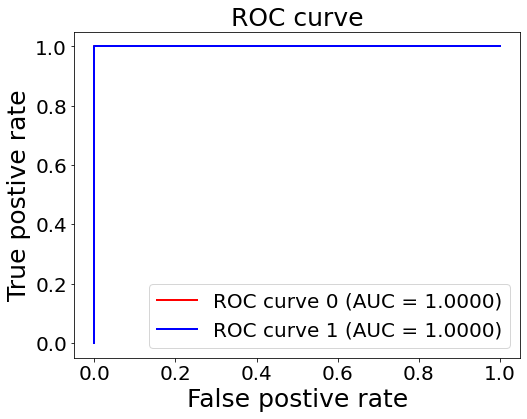

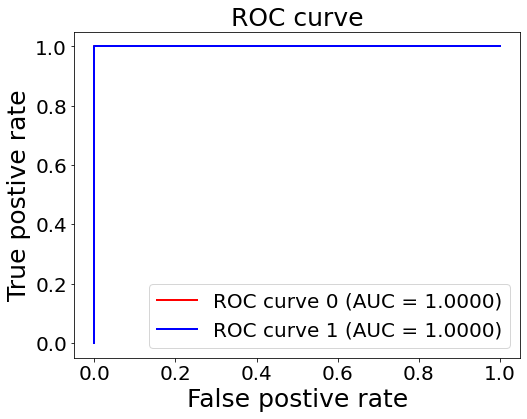

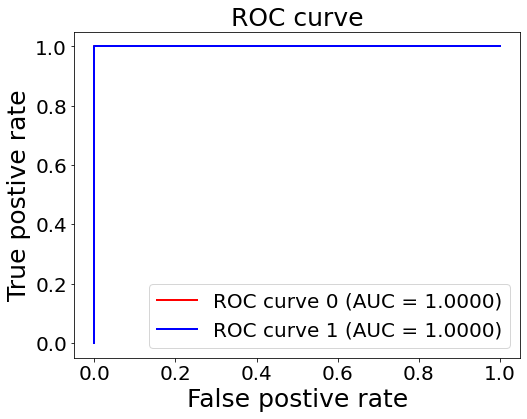

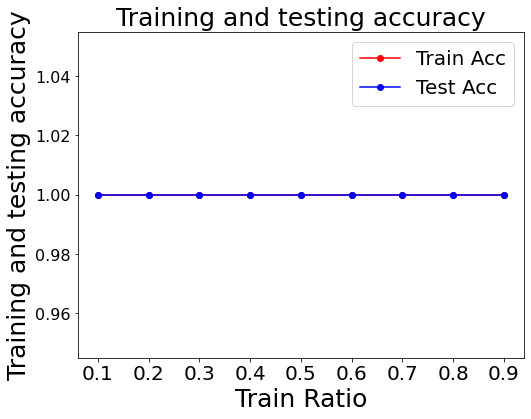

In [7]:
import time
import random
import sys
import numpy as np
import torch
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from statistics import mean, pstdev
import torch.nn.functional as F

#from model import *
#from dataloader import *

import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score,roc_curve,auc,classification_report,confusion_matrix

from tensorflow.keras.utils import to_categorical
#args = parser.parse_args(args=[])
#sns.set(font_scale=2)
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('cuda', action='store_true', default=False,
                    help='Use CUDA for training.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay for optimizer.')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--train_split', type=float, default=0.8,
                    help='Ratio of train split from entire dataset.Rest goes to test set')
parser.add_argument('--batch_size', type=int, default=16,
                    help='batch size for loading mini batches of data')
parser.add_argument('--dataset_name', type=str, default='Kaggle_Pretwitt',
                    help='Dataset name')
args = parser.parse_args(args=[])
#args = parser.parse_args()
if args.cuda:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.manual_seed(args.seed)
    else:
        print("Sorry no gpu found!!")
        device=torch.device('cpu')
        print("Running model on cpu")
else:
    device=torch.device('cpu')

#Setting seed to reproduce results
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

dataset = GraphDataset(root='brain/Github_Pretwitt/raw/', name=args.dataset_name, use_node_attr=True)
data_size = len(dataset)

#checking some of the data attributes comment out these lines if not needed to check
print("*"*10)
print(data_size)
print(dataset.num_features)
print(args.hidden)
print(args.dropout)
print(dataset.num_classes)
print("*"*10)

n_classes=dataset.num_classes
class_list=[]
for i in range(0,n_classes):
    class_list.append(i)
    

#printing confusion matrix
def show_confusion_matrix(validations, predictions):
    LABELS=["COVID","NON-COVID"]
    matrix = confusion_matrix(validations, predictions)
    print(matrix)
    

#applying k-fold cross validation
def crossvalid(dataset=None,k_fold=5):
    
    global precision,recall,f1
    
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction) 
    index=0
    test_accs=[]
    train_time=0
    test_time=0
    for i in range(k_fold):
        if(i==k_fold-1):
            print("Running for {} fold".format(index+1))
            index=index+1
            trll = 0
            trlr = i * seg
            vall = trlr
            valr = i * seg + seg
            trrl = valr
            trrr = total_size
            
            train_left_indices = list(range(trll,trlr))
            train_right_indices = list(range(trrl,trrr))
            
            train_indices = train_left_indices + train_right_indices
            val_indices = list(range(vall,valr))
            
            train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
            val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
            
            print(len(train_set),len(val_set))
            
            train_loader = DataLoader(train_set, batch_size=1,
                                              shuffle=True)
            val_loader = DataLoader(val_set, batch_size=1,
                                              shuffle=True)
                                              
            
            model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
            opt = optim.Adam(model.parameters(), lr=0.001)
            
            loss_values=[]
            accuracy_values=[]
            
            train_start=time.time()  
            for epoch in range(10):
                total_loss = 0
                model.train()
                for batch in train_loader:
                
                    opt.zero_grad()
                    embedding, pred, soft= model(batch)
                    label = batch.y
                    if task == 'node':
                        pred = pred[batch.train_mask]
                        label = label[batch.train_mask]
                    loss = model.loss(pred, label)
                    loss.backward()
                    opt.step()
                    total_loss += loss.item() * batch.num_graphs
                total_loss /= len(train_loader.dataset)
                writer.add_scalar("loss", total_loss, epoch)
    
                if epoch % 1 == 0:
                    train_acc = test(train_loader, model)
                    print("Epoch {}. Train Loss: {:.4f}. Train accuracy: {:.4f}".format(
                        epoch, total_loss, train_acc))
                    
                    loss_values.append(total_loss)
                    accuracy_values.append(train_acc)
                
                    writer.add_scalar("train accuracy", train_acc, epoch)
            
            train_end=time.time()
            print("Time taken for training: ",train_end-train_start)
            train_time+=(train_end-train_start)
            
            test_start=time.time()
            test_acc = test(val_loader, model, True)
            test_end=time.time()
            print("Test accuracy: {:.4f}".format(test_acc))
            print("Time taken for testing: ",test_end-test_start)
            test_time+=(test_end-test_start)
            
            fig = plt.figure(figsize=(8,6))
            ax = fig.add_subplot(111)
            ax.set_title('Training loss and accuracy',fontsize=25)
            plt.plot(loss_values, color='red',label='Loss')
            plt.plot(accuracy_values, color='blue',label='Accuracy')
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            ax.set_xlabel('Epoch',fontsize=25)
            ax.set_ylabel('Loss and Accuracy',fontsize=25)
            ax.legend(loc='best',fontsize=20)
            plt.savefig(f"{k_fold}-fold_"+args.dataset_name+"_"+str(i+1)+".svg",format="svg")
            
            test_accs.append(test_acc)
                
    precision/=k_fold
    recall/=k_fold
    f1/=k_fold
    avg_test=sum(test_accs)/len(test_accs)
    train_time/=k_fold
    test_time/=k_fold
    print("------------")
    print("{} fold test accuracy {:.4f}, precision {:.4f}, recall {:.4f}, F1-score {:.4f}".format(k_fold,avg_test,precision,recall,f1))
    print("Average training time {:.3f}, average testing time {:.3f}".format(train_time,test_time))    


def train(dataset, task, writer):
    crossvalid(dataset)
    
#function for calculating acc for different train-ratio
def eval_train_ratio(dataset, task, writer):
    
    train_ratios=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    test_accuracies=[]
    train_accuracies=[]
    for tr in train_ratios:
        if task == 'graph':
            data_size = len(dataset)
            train_loader = DataLoader(dataset[:int(data_size * tr)], batch_size=1, shuffle=True)
            test_loader = DataLoader(dataset[int(data_size * tr):], batch_size=1, shuffle=True)
        else:
            test_loader = train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
        print("Train ratio: {:.1f}. No of training graphs: {}. No of testing graphs: {}".format(tr,len(train_loader),len(test_loader)))
        
        model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
        opt = optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(10):
            total_loss = 0
            model.train()
            for batch in train_loader:
            
                opt.zero_grad()
                embedding, pred ,_= model(batch)
                label = batch.y
                if task == 'node':
                    pred = pred[batch.train_mask]
                    label = label[batch.train_mask]
                loss = model.loss(pred, label)
                loss.backward()
                opt.step()
                total_loss += loss.item() * batch.num_graphs
            total_loss /= len(train_loader.dataset)
        train_acc = test(train_loader, model)
        test_acc = test(test_loader, model, True)
        print("Test accuracy: {:.4f}".format(test_acc))
        test_accuracies.append(test_acc)
        train_accuracies.append(train_acc)
        
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.set_title('Training and testing accuracy',fontsize=25)
    plt.plot(train_ratios, train_accuracies, color='red', marker= 'o',label='Train Acc')
    plt.plot(train_ratios, test_accuracies, color='blue',marker= 'o', label='Test Acc')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=16)
    ax.set_xlabel('Train Ratio',fontsize=25)
    ax.set_ylabel('Training and testing accuracy',fontsize=25)
    ax.legend(loc='best',fontsize=20)
    #plt.show()
    plt.savefig(f"iterative_training_"+args.dataset_name+".svg",format="svg")
    
def test(loader, model, is_test=False,is_validation=False):
    global precision,recall,f1
    global class_list,n_classes
    global cnt
    model.eval()
    
    correct = 0
    glabel=[]
    glabel1=[]
    gpred=[]
    gscore=[]
    for data in loader:
        with torch.no_grad():
            emb, pred,soft = model(data)
            var=soft.numpy()[0]
            pred = pred.argmax(dim=1)
            label = data.y
            
            
            if(is_test): 
                glabel.append(label.numpy()[0])
                glabel1.append(label.numpy())   
                gpred.append(pred.numpy()[0])
                gscore.append(var)
            

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    
    if(is_test):
        glabel=np.array(glabel)
        glabel1=np.array(glabel1)
        gpred=np.array(gpred)
        gscore=np.array(gscore)
        enlabel=to_categorical(glabel1,n_classes)
        
        
        
        p=precision_score(glabel, gpred, average="micro")
        r=recall_score(glabel, gpred, average="micro")
        f=f1_score(glabel, gpred, average="micro")
        
        print('F1: {}'.format(f))
        print('Precision: {}'.format(p))
        print('Recall: {}'.format(r))
        precision+=p
        recall+=r
        f1+=f
        
        print("\n...confusion matrix and classification report....\n")
        show_confusion_matrix(glabel,gpred)
        print(classification_report(glabel,gpred,digits=5))

        
        #generate roc curve
        tpr=dict()
        fpr=dict()
        roc_auc=dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _= roc_curve(enlabel[:, i], gscore[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.set_title('ROC curve',fontsize=25)
        colors=['red','blue','green','yellow','purple','orange']
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i],lw=2,label='ROC curve {0} (AUC = {1:0.4f})'
             ''.format(i, roc_auc[i]))    
        ax.set_xlabel('False postive rate',fontsize=25)
        ax.set_ylabel('True postive rate',fontsize=25)
        ax.legend(loc='best',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(f"roc_"+args.dataset_name+"_"+str(cnt)+".svg",format="svg")
        cnt+=1
        
    return correct / total
dataset = dataset.shuffle()
task = 'graph'
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

#globals 
precision=0
recall=0
f1=0

cnt=1

train(dataset, task, writer)
eval_train_ratio(dataset, task, writer)

In [4]:
print(classification_report(glabel,gpred),digits=4)

NameError: name 'glabel' is not defined